# Análisis de Datos - Software de Planta Industrial
En este notebook se realiza un análisis sobre datos extraídos de un software utilizado en diferentes procesos de una planta fabril.

Se pretende obtener un **resumen por operario** que contenga los siguientes datos:
- Horas totales en un periodo de tiempo dado.
- Horas implicadas en cada proceso productivo.

Por otro lado, se realiza un análisis del proceso de **Corte de Ladrillos** evaluando el rendimiento (ciclos/hora) y la calidad (% de conformidad) a lo largo de un periodo de tiempo determinado para cada producto procesado.

## Importar librerías

In [1]:
from sqlalchemy import text
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import sys
sys.path.append("..")

from scripts.db_utils import get_engine

## Conectar a base de datos

In [2]:
engine = get_engine()

## Vista general de tablas

In [3]:
query = "SHOW TABLES"
pd.read_sql(query, engine)

,Tables_in_mtdb
0,config_terminales
1,paradas_no_prog
2,paradas_prog
3,partes_de_trabajo
4,pprod_cortelad
5,pprod_embolsado
6,pprod_inyeccion
7,usuarios


## Análisis de Operarios

### Cargar datos de operarios
Se obtienen los datos a partir de una consulta SQL que une las planillas de producción de los procesos (`pprod_cortelad`, `pprod_inyeccion`, `pprod_embolsado`) con la tabla `usuarios`, agrupando por `usuarios.nombre` y filtrando solamente los que tienen horas en procesos de producción `hrs_total > 0`, dentro del periodo de tiempo especificado.


In [4]:
fecha_desde = '2023-04-01'
fecha_hasta = '2023-04-30'

query = text('''
SELECT 
    u.nombre AS nombre,
    COALESCE(SUM(CASE WHEN t.origen = 'cortelad'  THEN t.total_horas END), 0) AS hrs_cortelad,
    COALESCE(SUM(CASE WHEN t.origen = 'inyeccion' THEN t.total_horas END), 0) AS hrs_inyeccion,
    COALESCE(SUM(CASE WHEN t.origen = 'embolsado' THEN t.total_horas END), 0) AS hrs_embolsado,
    COALESCE(SUM(t.total_horas), 0) AS hrs_total
FROM 
    usuarios u
LEFT JOIN (
    SELECT
        id_usuario,
        TIMESTAMPDIFF(HOUR, fh_inicio, fh_fin) AS total_horas,
        'cortelad' AS origen
    FROM pprod_cortelad
    WHERE fh_inicio BETWEEN :fecha_desde AND :fecha_hasta
    
    UNION ALL
    
    SELECT
        id_usuario,
        TIMESTAMPDIFF(HOUR, fh_inicio, fh_fin) AS total_horas,
        'inyeccion' AS origen
    FROM pprod_inyeccion
    WHERE fh_inicio BETWEEN :fecha_desde AND :fecha_hasta
    
    UNION ALL
    
    SELECT
        id_usuario,
        TIMESTAMPDIFF(HOUR, fh_inicio, fh_fin) AS total_horas,
        'embolsado' AS origen
    FROM pprod_embolsado
    WHERE fh_inicio BETWEEN :fecha_desde AND :fecha_hasta
) t 
    ON u.id_usuario = t.id_usuario
GROUP BY 
    u.nombre
HAVING 
    hrs_total > 0;

''')

df_operarios = pd.read_sql(query, engine, params={"fecha_desde": fecha_desde, "fecha_hasta": fecha_hasta,})
df_operarios

,nombre,hrs_cortelad,hrs_inyeccion,hrs_embolsado,hrs_total
0,OPERARIO 2,0.0,57.0,41.0,98.0
1,OPERARIO 4,124.0,0.0,0.0,124.0
2,OPERARIO 7,108.0,0.0,0.0,108.0
3,OPERARIO 9,0.0,94.0,4.0,98.0
4,OPERARIO 10,0.0,137.0,0.0,137.0
5,OPERARIO 11,0.0,116.0,0.0,116.0


### Visualización

Se presentan las horas involucradas por proceso para cada operario utilizando el apilamiento de columnas a modo de visualizar fácilmente la ponderación de cada actividad en el total de horas durante el periodo de interés.

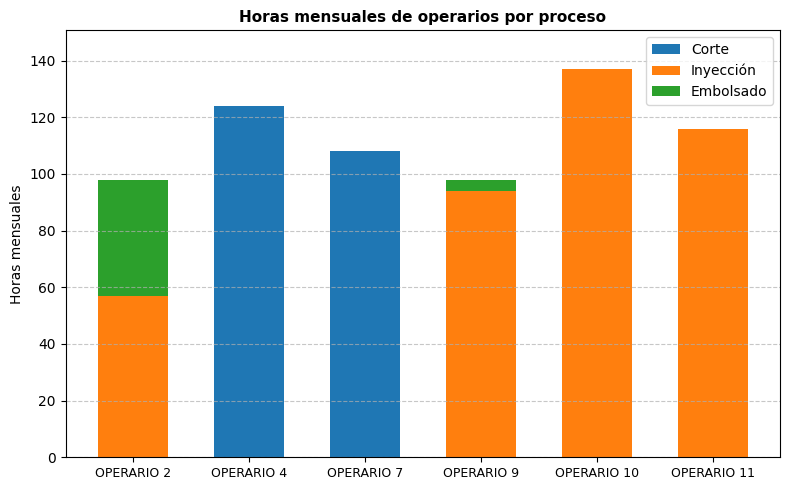

In [5]:
plt.figure(figsize=(8, 5))
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
columns_width = 0.6

plt.bar(df_operarios["nombre"], df_operarios["hrs_cortelad"], label="Corte", color=colors[0], width=columns_width)
plt.bar(df_operarios["nombre"], df_operarios["hrs_inyeccion"], bottom=df_operarios["hrs_cortelad"], label="Inyección", color=colors[1], width=columns_width)
plt.bar(df_operarios["nombre"], df_operarios["hrs_embolsado"], bottom=df_operarios["hrs_cortelad"] + df_operarios["hrs_inyeccion"], label="Embolsado", color=colors[2], width=columns_width)

plt.title("Horas mensuales de operarios por proceso", fontsize=11, weight="bold")
plt.legend(fontsize=10, loc="upper right")
plt.ylabel("Horas mensuales")
plt.xticks(fontsize=9)
plt.ylim(0, df_operarios.drop(["nombre", "hrs_total"], axis=1).sum(axis=1).max() * 1.1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

## Análisis de Proceso (Corte de Ladrillos)

### Cargar datos de planillas de producción
Se realiza una consulta SQL que funciona en dos niveles:
1. Una subquery que, por un lado, asigna a cada planilla de producción el `tipo_ladrillo` que fue procesado a través de un `CASE` que verifica cuál tiene una producción `> 0` siguiendo un orden de prioridad `lad12conf > lad10conf > lad16conf`, y por otro, determina el porcentaje de `conformidad` utilizando otra sentencia `CASE`.
2. Con la vista generada por la subquery filtra los datos por `fecha` y los agrupa por `tipo_ladrillo`, calculando las variables que resultan de interés analizar:
   - **Ciclos realizados por hora:**: a partir de la cantidad de material consumido `cons_bloques` y `hs_operativas` (que ya contempla los tiempos de paradas dentro de la planilla de producción)
   - **% de Conformidad:** a partir de las cantidad de producción conforme y producción no conforme, por ejemplo `lad12conf` y `lad12nc`.


In [6]:
fecha_desde = '2023-04-01'
fecha_hasta = '2023-04-30'

query = text('''
SELECT
    DATE(fh_inicio) AS fecha,
    tipo_ladrillo,
    ROUND((SUM(cons_bloques) / SUM(hs_operativas)), 2) AS ciclos_hora,
    ROUND(AVG(conformidad), 2) AS conformidad
FROM (
    SELECT
        fh_inicio,
        hs_operativas,
        cons_bloques,
        CASE
            WHEN lad12conf > 0 THEN 'lad12'
            WHEN lad10conf > 0 THEN 'lad10'
            WHEN lad16conf > 0 THEN 'lad16'
        END AS tipo_ladrillo,
        CASE
            WHEN lad12conf > 0 THEN (lad12conf / (lad12conf + lad12nc)) * 100
            WHEN lad10conf > 0 THEN (lad10conf / (lad10conf + lad10nc)) * 100
            WHEN lad16conf > 0 THEN (lad16conf / (lad16conf + lad16nc)) * 100
        END AS conformidad        
    FROM pprod_cortelad
    WHERE (lad10conf > 0 OR lad12conf > 0 OR lad16conf > 0)
        AND cons_bloques > 0
        AND fh_inicio BETWEEN :fecha_desde AND :fecha_hasta
) AS sub
GROUP BY fecha, tipo_ladrillo
ORDER BY fecha, tipo_ladrillo;
''')

df_proceso = pd.read_sql(query, engine, params={"fecha_desde": fecha_desde, "fecha_hasta": fecha_hasta,})
df_lad10 = df_proceso[df_proceso["tipo_ladrillo"] == "lad10"]
df_lad12 = df_proceso[df_proceso["tipo_ladrillo"] == "lad12"]
df_lad16 = df_proceso[df_proceso["tipo_ladrillo"] == "lad16"]

df_proceso

,fecha,tipo_ladrillo,ciclos_hora,conformidad
0,2023-04-03,lad12,2.67,99.56
1,2023-04-04,lad12,2.80,98.84
2,2023-04-05,lad10,1.60,98.61
3,2023-04-06,lad12,0.40,100.00
4,2023-04-10,lad12,1.62,99.66
5,2023-04-11,lad16,1.00,95.83
6,2023-04-12,lad10,1.25,98.68
7,2023-04-13,lad10,1.70,100.00
8,2023-04-14,lad12,1.12,96.08
9,2023-04-17,lad10,1.38,99.92


### Visualización

Se presentan rendimiento (ciclos/hora) y % de conformidad agrupados por producto a lo largo del periodo de tiempo configurado.

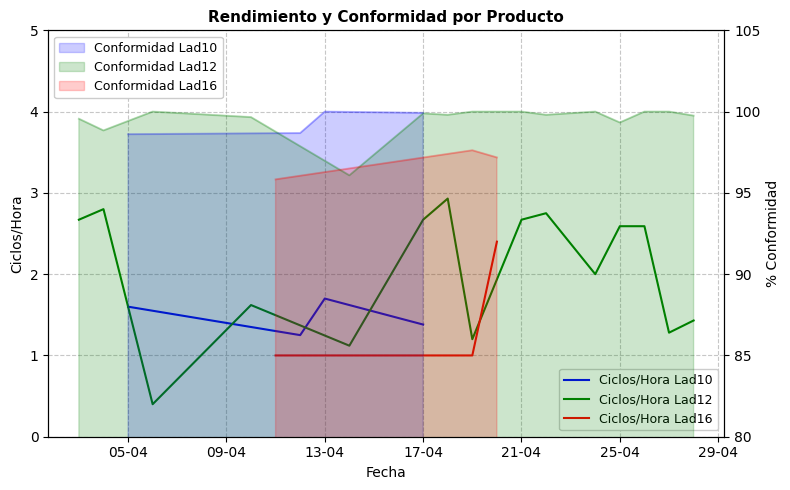

In [7]:
fig, ax1 = plt.subplots(figsize=(8,5))
colors = ["blue", "green", "red"]

ax1.plot(df_lad10['fecha'], df_lad10['ciclos_hora'], color='blue', label='Ciclos/Hora Lad10')
ax1.plot(df_lad12['fecha'], df_lad12['ciclos_hora'], color='green', label='Ciclos/Hora Lad12')
ax1.plot(df_lad16['fecha'], df_lad16['ciclos_hora'], color='red', label='Ciclos/Hora Lad16')
ax2 = ax1.twinx()
ax2.plot(df_lad10['fecha'], df_lad10['conformidad'], color='blue', alpha=0.2)
ax2.plot(df_lad12['fecha'], df_lad12['conformidad'], color='green', alpha=0.2)
ax2.plot(df_lad16['fecha'], df_lad16['conformidad'], color='red', alpha=0.2)
ax2.fill_between(
    df_lad10['fecha'],
    df_lad10[f'conformidad'],
    alpha=0.2,
    color=colors[0],
    label=f'Conformidad Lad10'
)
ax2.fill_between(
    df_lad12['fecha'],
    df_lad12[f'conformidad'],
    alpha=0.2,
    color=colors[1],
    label=f'Conformidad Lad12'
)
ax2.fill_between(
    df_lad16['fecha'],
    df_lad16[f'conformidad'],
    alpha=0.2,
    color=colors[2],
    label=f'Conformidad Lad16'
)

ax1.set_xlabel('Fecha')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
ax1.set_ylabel('Ciclos/Hora')
ax2.set_ylabel('% Conformidad')

ax1.set_ylim(0, 5)
ax2.set_ylim(80, 105)
ax1.legend(fontsize=9, loc='lower right', facecolor="white", framealpha=1)
ax2.legend(fontsize=9, loc='upper left', facecolor="white", framealpha=1)
ax1.grid(True, linestyle="--", alpha=0.7)

plt.title('Rendimiento y Conformidad por Producto', fontsize=11, weight="bold")
plt.tight_layout()
plt.show()